# Importações


In [40]:
import urllib
from itertools import product
from os import getenv
from sqlalchemy import create_engine
from dotenv import load_dotenv

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from fuzzywuzzy import process

# Connection


connection.py


In [41]:
# cSpell: disable=invalid-name
load_dotenv()


class Connection:
    """
    Class Connection
    """

    def __init__(self):
        """
        Constructor

        Args:
            user (str): user
            password (str): password
            database (str): database
            driver (str): driver
            server (str): server

        Usage:
            >>> from connection import Connection
            >>> connection = Connection()
            >>> connection.get_connection()
        """
        self.__user = getenv("PYMSSQL_USER")
        self.__password = getenv("PYMSSQL_PASSWORD")
        self.__database = getenv("PYMSSQL_DATABASE_AUTOMACAO")
        self.__driver = "{ODBC Driver 17 for SQL Server}"
        self.__server = getenv("PYMSSQL_SERVER")

    def get_connection_automacao(self):
        """
        Get connection

        Returns:
            object: connection

        Usage:
            >>> from connection import Connection
            >>> connection = Connection()
            >>> connection.get_connection()
        """
        try:
            params = urllib.parse.quote_plus(
                f"DRIVER={self.__driver};"
                f"SERVER={self.__server};"
                f"DATABASE={self.__database};"
                f"UID={self.__user};"
                f"PWD={self.__password};"
            )
            # pylint: disable=consider-using-f-string
            conexao_automacao = create_engine(
                "mssql+pyodbc:///?odbc_connect=%s" % params
            )
            return conexao_automacao
        # pylint: disable=broad-except
        except Exception as error:
            print(f"Error: {error}")
            return None

db_read.py


In [42]:
# cSpell: disable=invalid-name
class Read(Connection):
    """
    Class Read
    Read data from the database and return a pandas dataframe
    Create query to be executed in the database
    """

    # pylint: disable=useless-super-delegation
    def __init__(self):
        """
        Constructor
        """
        super().__init__()

    def get_automacao_data(self, query: str) -> pd.DataFrame:
        """
        Get data from database AUTOMACAO and return a pandas dataframe.

        Parameters
        ----------
        query : str
            Query to be executed in the database

        Returns
        -------
        pandas dataframe
            Dataframe with the query result
        """
        try:
            connection = self.get_connection_automacao()
            data = pd.read_sql(query, connection)
            return data
        # pylint: disable=broad-except
        except Exception as error:
            print(f"Error: {error}")
            return None

    def create_automacao_query(
        self, table: str, where: str = None, orderby: str = None
    ) -> str:
        """
        Create query to be executed in the database AUTOMACAO.

        Parameters
        ----------
        table : str
            Table name
        where : str
            Where clause (optional)
        orderby : str
            Order by clause (optional)

        Returns
        -------
        str
            Query to be executed in the database
        """
        query = f"SELECT * FROM AUTOMACAO.dbo.{table}"

        if where:
            query += f" WHERE {where}"

        if orderby:
            query += f" ORDER BY {orderby}"

        return query

## Criando a query e recebendo dados do Banco de Dados


In [43]:
# cSpell: disable=invalid-name
# Dia de hoje para uso no gráfico
now = pd.to_datetime("today")
today = now.strftime("%Y-%m-%d")

# Encontrando primeiro e último dia do mês anterior
first_day_this_month = now.replace(day=1)  # primeiro dia do mês atual
last_day_month = first_day_this_month - timedelta(
    days=1
)  # último dia do mês anterior
first_day_month = last_day_month.replace(day=1)  # primeiro dia do mês anterior

# mantendo o formato de data e removendo o horário
last_day_month = last_day_month.strftime("%Y-%m-%d")
first_day_month = first_day_month.strftime("%Y-%m-%d")
first_day_this_month = first_day_this_month.strftime("%Y-%m-%d")

print(f"Primeiro dia do mês anterior: {first_day_month}")
print(f"Último dia do mês anterior: {last_day_month}")
print(f"Primeiro dia do mês atual: {first_day_this_month}")

# Instancia a classe Read
DB_read = Read()

# Query para obter os dados do mês anterior
query_occ = DB_read.create_automacao_query(
    table="maquina_ocorrencia",
    where=f"data_registro >= '{first_day_this_month}'",
)

query_info = DB_read.create_automacao_query(
    table="maquina_info", where=f"data_registro >= '{first_day_this_month}'"
)

query_maq_cadastro = DB_read.create_automacao_query(
    table="maquina_cadastro",
    orderby="linha, data_registro DESC, hora_registro DESC",
)

# Leitura do Banco de Dados
df_occ = DB_read.get_automacao_data(query_occ)
df_info = DB_read.get_automacao_data(query_info)
df_maq_cadastro = DB_read.get_automacao_data(query_maq_cadastro)

# df_occ.to_html("teste.html")

Primeiro dia do mês anterior: 2023-12-01
Último dia do mês anterior: 2023-12-31
Primeiro dia do mês atual: 2024-01-01


Testes de Saída do Banco de Dados


In [44]:
df_occ

,recno,maquina_id,motivo_id,problema,solucao,data_registro,hora_registro,usuario_id
0,2638,TMF006,12,,,2024-01-02,01:16:52,000453
1,2639,TMF013,08,,,2024-01-02,01:17:04,000453
2,2640,TMF010,08,,,2024-01-02,01:17:20,000453
3,2641,TMF010,12,,,2024-01-02,01:18:45,000453
4,2642,TMF006,12,,,2024-01-03,08:14:58,000807
...,...,...,...,...,...,...,...,...
386,3024,TMF010,05,,,2024-01-16,08:08:49,000807
387,3025,TMF011,12,Linha backup,,2024-01-16,08:11:29,000838
388,3026,TMF005,08,Robô travou,,2024-01-16,08:23:38,000838
389,3027,TMF002,08,Robô travou,,2024-01-16,08:24:02,000838


In [45]:
df_info

,recno,maquina_id,status,ciclo_1_min,ciclo_15_min,contagem_total_ciclos,contagem_total_produzido,turno,data_registro,hora_registro,tempo_parada,tempo_rodando
0,667577,TMF005,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:14.246666,0.0,0.0
1,667578,TMF002,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:15.253333,0.0,0.0
2,667579,TMF015,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:16.253333,0.0,0.0
3,667580,TMF011,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:17.253333,0.0,0.0
4,667581,TMF014,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:18.253333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149919,817496,TMF014,true,10.0,150.0,2072.0,2064.0,MAT,2024-01-16,09:40:51.333333,0.0,0.0
149920,817497,TMF004,true,11.0,139.0,1828.0,0.0,MAT,2024-01-16,09:40:52.336666,0.0,0.0
149921,817498,TMF004,true,11.0,139.0,1830.0,0.0,MAT,2024-01-16,09:40:53.336666,0.0,0.0
149922,817499,TMF003,true,8.0,150.0,1902.0,1868.0,MAT,2024-01-16,09:40:54.340000,0.0,0.0


In [46]:
df_maq_cadastro

,recno,maquina_id,fabrica,linha,data_registro,hora_registro,usuario_id
0,55,TMF001,,0,2024-01-14,16:13:05,000264
1,51,TMF003,,0,2023-11-11,12:41:46,000264
2,48,TMF005,,0,2023-11-11,12:37:43,000264
3,47,TMF014,,0,2023-10-29,11:44:53,000264
4,43,TMF005,,0,2023-10-22,12:32:23,000264
5,42,TMF014,,0,2023-10-14,14:58:15,000264
6,39,TMF005,0,0,2023-10-06,15:53:45,000264
7,38,TMF003,,0,2023-10-02,08:17:14,002131
8,37,TMF003,,0,2023-09-30,16:35:54,000264
9,36,TMF003,,0,2023-09-30,16:35:37,000264


# Service


clean_data.py


In [47]:
class CleanData:
    """
    Classe para limpeza dos dados

    Atributos:
        df (pd.DataFrame): Dataframe com os dados a serem limpos

    Métodos:
        clean_maq_cadastro: Limpa os dados de cadastro das máquinas

    """

    def __init__(self):
        pass

    def clean_maq_cadastro(self, cadastro: pd.DataFrame) -> pd.DataFrame:
        """
        Limpa os dados de cadastro das máquinas

        Args:
        -----
            data (pd.DataFrame): Dataframe com os dados a serem limpos

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados limpos

        Exemplo:
        --------

            >>> from app.service.clean_data import CleanData
            >>> import pandas as pd
            >>> df = pd.DataFrame({'maquina_id': [TMF001, TMF002, TMF003], 'linha': [1, 2, 3],
            'fabrica': [1, 2, 2], 'data_registro': ['2021-01-01', '2021-01-01', '2021-01-01'],
            'hora_registro': ['00:00:00.000', '00:00:00.000', '00:00:00.000'], 'recno': [1, 2, 3],
            usuario_id: [00532, 00533, 00534]})
            >>> clean_data = CleanData()
            >>> df_clean = clean_data.clean_maq_cadastro(df)
            >>> df_clean
                maquina_id  linha  fabrica data_hora_registro       usuario_id
            0     TMF001      1        1    2021-01-01 00:00:00      532
            1     TMF002      2        2    2021-01-01 00:00:00      533
            2     TMF003      3        2    2021-01-01 00:00:00      534


        """

        # Remover rows onde a linha é 0
        df_cadastro = cadastro[cadastro["linha"] != 0]

        # Remover linhas duplicadas (erros de cadastro)
        df_cadastro = df_cadastro.drop_duplicates(
            subset=["data_registro", "linha"], keep="first"
        )

        # Criar nova coluna combinando data e hora
        df_cadastro["data_hora_registro"] = (
            df_cadastro["data_registro"].astype(str)
            + " "
            + df_cadastro["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Converter coluna data_hora_registro para datetime
        df_cadastro["data_hora_registro"] = pd.to_datetime(
            df_cadastro["data_hora_registro"], format="%Y-%m-%d %H:%M:%S"
        )

        # Remover colunas desnecessárias
        df_cadastro = df_cadastro.drop(
            columns=["recno", "data_registro", "hora_registro"]
        )

        # Ordenar dataframe para facilitar trabalho futuro
        df_cadastro = df_cadastro.sort_values(
            by=["maquina_id", "data_hora_registro"], ascending=[True, False]
        )

        # reiniciar o index
        df_cadastro = df_cadastro.reset_index(drop=True)

        return df_cadastro

    def maq_info(self, info: pd.DataFrame) -> pd.DataFrame:
        """
        Limpa os dados de cadastro das máquinas

        Args:
        -----
            data (pd.DataFrame): Dataframe com os dados a serem limpos

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados limpos

        Exemplo:
        --------

            >>> from app.service.clean_data import CleanData
            >>> import pandas as pd
            >>> df = pd.DataFrame({'maquina_id': [TMF001, TMF002, TMF003], 'status'[False, True, True], 'turno'[MAT, VES, NOT], 'data_registro': ['2021-01-01', '2021-01-01', '2021-01-01'],
            'hora_registro': ['00:00:00.000', '00:00:00.000', '00:00:00.000'], 'recno': [1, 2, 3],
            })
            >>> clean_data = CleanData()
            >>> df_clean = clean_data.clean_maq_info(df)
            >>> df_clean
                maquina_id  status  turno   data_hora_registro      data_hora_final         tempo_registro_min
            0     TMF001    parada    MAT   2021-01-01 00:00:00     2021-01-01 00:01:00     480
            1     TMF002    rodando   VES   2021-01-01 00:00:00     2021-01-01 00:01:00     10
            2     TMF003    rodando   NOT   2021-01-01 00:00:00     2021-01-01 00:01:00     10

        """
        # Ordenar por maquina_id e data_registro, hora_registro

        df_info = info.sort_values(
            by=["maquina_id", "data_registro", "hora_registro", "turno"],
        )

        # Criar nova coluna combinando data e hora
        df_info["data_hora_registro"] = (
            df_info["data_registro"].astype(str)
            + " "
            + df_info["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Descartar colunas desnecessárias
        df_info = df_info.drop(
            columns=["recno", "data_registro", "hora_registro"]
        )

        # Se for a primeira linha de cada máquina e o turno for VES, alterar para NOT
        df_info.loc[
            (df_info["turno"] == "VES")
            & (df_info["maquina_id"] != df_info["maquina_id"].shift()),
            "turno",
        ] = "NOT"

        # Criar nova coluna status_change para identificar mudança de status
        df_info["status_change"] = df_info["status"].ne(
            df_info["status"].shift()
        )

        # Criar coluna para identificar a mudança de máquina
        df_info["maquina_change"] = df_info["maquina_id"].ne(
            df_info["maquina_id"].shift()
        )

        # criar coluna para consolidar mudança de status e de máquina
        df_info["change"] = (
            df_info["status_change"] | df_info["maquina_change"]
        )

        # Criar coluna para identificar a mudança de turno
        df_info["turno_change"] = df_info["turno"].ne(df_info["turno"].shift())

        # Atualizar coluna change para incluir mudança de turno
        df_info["change"] = df_info["change"] | df_info["turno_change"]

        # Agrupar por maquina e identificar data e hora da última mudança de status
        df_info["change_time"] = (
            df_info.groupby("maquina_id")["data_hora_registro"]
            .shift(0)
            .where(df_info["change"])
        )

        # Remover as linhas onde change_time é nulo
        df_info.dropna(subset=["change_time"], inplace=True)

        # Criar nova coluna com a data_hora_final do status
        df_info["data_hora_final"] = (
            df_info.groupby("maquina_id")["data_hora_registro"]
            .shift(-1)
            .where(~df_info["maquina_change"])
        )

        # Atualizar coluna data_hora_final onde maquina_change é True
        df_info.loc[df_info["maquina_change"], "data_hora_final"] = df_info[
            "change_time"
        ].shift(-1)

        # Remover colunas desnecessárias
        df_info.drop(
            columns=[
                "status_change",
                "maquina_change",
                "turno_change",
                "change",
                "change_time",
            ],
            inplace=True,
        )

        # Remover linhas onde data_hora_final é nulo
        df_info.dropna(subset=["data_hora_final"], inplace=True)

        # Cria nova coluna tempo_registro_min para calcular o tempo de registro em minutos
        df_info["tempo_registro_min"] = (
            pd.to_datetime(df_info["data_hora_final"])
            - pd.to_datetime(df_info["data_hora_registro"])
        ).dt.total_seconds() / 60

        # Arredondar tempo_registro_min e converter para inteiro
        df_info["tempo_registro_min"] = (
            df_info["tempo_registro_min"].round(0).astype(int)
        )

        # Incluir um status in_test para os casos onde o status true permanece por menos de 10 minutos
        df_info = df_info.astype(
            {"status": str}
        )  # para evitar erros de comparação
        df_info.loc[
            (df_info["status"] == "true")
            & (df_info["tempo_registro_min"] < 10),
            "status",
        ] = "in_test"

        # Ajustar nomenclatura dos status
        df_info.loc[df_info["status"] == "true", "status"] = "rodando"
        df_info.loc[df_info["status"] == "false", "status"] = "parada"

        # Remover colunas desnecessárias
        df_info.drop(
            columns=[
                "ciclo_1_min",
                "ciclo_15_min",
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "tempo_parada",
                "tempo_rodando",
            ],
            inplace=True,
        )

        # Ajustar o index
        df_info.reset_index(drop=True, inplace=True)

        return df_info

    def get_stops_data(self, info: pd.DataFrame) -> pd.DataFrame:
        """
        Retorna um dataframe com os dados de paradas consolidados

        Args:
        -----
            df (pd.DataFrame): Dataframe com os dados de paradas

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados de paradas consolidados

        Exemplo:
        --------

            >>> from app.service.get_stops_data import GetStopsData
            >>> import pandas as pd
            >>> get_stops_data = GetStopsData()
            >>> df_stops = get_stops_data.get_stops_data(df)

        """

        # Copiar o dataframe
        df = info.copy()

        # Transformar data e hora em datetime
        df["data_hora_registro"] = pd.to_datetime(df["data_hora_registro"])
        df["data_hora_final"] = pd.to_datetime(df["data_hora_final"])

        # Ordenar por maquina_id, turno, data_hora_registro
        df.sort_values(
            by=["maquina_id", "turno", "data_hora_registro"], inplace=True
        )

        # Criar coluna data_hora_registro_turno para identificar onde está rodando
        df["rodando"] = df["status"] == "rodando"

        # Cria uma coluna grupo para identificar os grupos de paradas
        df["grupo"] = (
            (df["rodando"] != df["rodando"].shift())
            | (df["maquina_id"] != df["maquina_id"].shift())
            | (df["turno"] != df["turno"].shift())
            | (
                df["data_hora_registro"].dt.date
                != df["data_hora_registro"].shift().dt.date
            )
        )

        # Soma o tempo de parada por grupo
        df["grupo"] = df["grupo"].cumsum()

        # Agregar os dados por grupo
        df = (
            df.groupby("grupo")
            .agg(
                {
                    "maquina_id": "first",
                    "turno": "first",
                    "status": "first",
                    "tempo_registro_min": "sum",
                    "data_hora_registro": "first",
                    "data_hora_final": "last",
                }
            )
            .reset_index(drop=True)
        )

        # Ordenar por maquina_id, data_hora_registro
        df.sort_values(by=["maquina_id", "data_hora_registro"], inplace=True)

        # Substituir status in_test por parada
        df.loc[df["status"] == "in_test", "status"] = "parada"

        # Substituir valores nulos por np.nan
        df.fillna(np.nan, inplace=True)

        # Reiniciar o index
        df.reset_index(drop=True, inplace=True)

        return df

    def dayofweek_adjust(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Ajusta o dia da semana para incluir paradas programadas

        Args:
        -----
            df (pd.DataFrame): Dataframe com os dados de paradas

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados de paradas ajustados

        Exemplo:
        --------

            >>> from app.service.get_stops_data import GetStopsData
            >>> import pandas as pd
            >>> get_stops_data = GetStopsData()
            >>> df_stops = get_stops_data.dayofweek_adjust(df)

        """

        # Garantir que a coluna data_hora_registro é datetime
        df["data_hora_registro"] = pd.to_datetime(df["data_hora_registro"])

        # Identificar os domingos
        df["domingo"] = df["data_hora_registro"].dt.dayofweek == 6

        # Listar feriados
        feriados = pd.read_csv("../database/feriados.csv")

        # Converter a coluna data para datetime
        feriados["feriados"] = pd.to_datetime(feriados["feriados"])

        # Identificar os feriados
        df["feriado"] = df["data_hora_registro"].dt.date.isin(
            feriados["feriados"].dt.date
        )

        # Identificar os dias após os feriados
        feriados["dia_apos_feriado"] = feriados["feriados"] + pd.Timedelta(
            days=1
        )
        df["dia_apos_feriado"] = df["data_hora_registro"].dt.date.isin(
            feriados["dia_apos_feriado"].dt.date
        )

        # Identificar sábados
        df["sabado"] = df["data_hora_registro"].dt.dayofweek == 5

        # Criar nova coluna unindo domingo, feriado e dia após feriado e descartar
        # as colunas domingo, feriado e dia após feriado
        df["domingo_feriado_emenda"] = (
            df["domingo"]
            | df["feriado"]
            | df["dia_apos_feriado"]
            | df["sabado"]
        )
        df.drop(
            columns=["domingo", "feriado", "dia_apos_feriado"], inplace=True
        )

        return df

    def clean_maq_info(self, info: pd.DataFrame) -> pd.DataFrame:
        """Agrupa funções de limpeza dos dados de info das máquinas para parada

        Args:
            info (pd.DataFrame): Info das máquinas do Banco de Dados

        Returns:
            pd.DataFrame: Dataframe com os dados limpos
        """

        df_info = info.copy()

        df_clean = self.maq_info(df_info)
        df_clean = self.get_stops_data(df_clean)
        df_clean = self.dayofweek_adjust(df_clean)

        return df_clean

    def clean_maq_occ(self, occ: pd.DataFrame) -> pd.DataFrame:
        """
        Limpa os dados de cadastro das máquinas

        Args:
        -----
            data (pd.DataFrame): Dataframe com os dados a serem limpos

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados limpos

        Exemplo:


        """

        # Motivos de Parada
        motivos = {
            1: "Ajustes",
            2: "Troca de Bobina",
            3: "Refeição",
            4: "Reunião",
            5: "Café e Ginástica Laboral",
            6: "Limpeza",
            7: "Manutenção Elétrica",
            8: "Manutenção Mecânica",
            9: "Material em Falta",
            10: "Setup de Sabor",
            11: "Setup de Tamanho",
            12: "Parada Programada",
            13: "Intervenção de Qualidade",
            14: "Linha Cheia",
            15: "Treinamento",
            16: "Limpeza Industrial",
        }

        # Modificar coluna motivo_id para int
        df_occ = occ.astype({"motivo_id": int})

        # Unir as colunas de data e hora
        df_occ["data_hora_registro"] = (
            df_occ["data_registro"].astype(str)
            + " "
            + df_occ["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Criar coluna motivo_nome com base no dicionário motivos
        df_occ["motivo_nome"] = df_occ["motivo_id"].map(motivos)

        # Ajustar problema e solucao se a string estiver vazia
        df_occ["problema"] = df_occ["problema"].replace("", np.nan)
        df_occ["solucao"] = df_occ["solucao"].replace("", np.nan)

        # Se o problema for nulo, copiar o motivo_nome para o problema, exceto para os motivos 1, 7, 8, 9, 14,
        df_occ.loc[
            df_occ["problema"].isnull()
            & ~df_occ["motivo_id"].isin([1, 7, 8, 9, 14]),
            "problema",
        ] = df_occ["motivo_nome"]

        # Definir ordem das colunas
        df_occ = df_occ[
            [
                "maquina_id",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro",
                "usuario_id",
            ]
        ]

        return df_occ

    def clean_maq_info_prod(self, info: pd.DataFrame) -> pd.DataFrame:
        """
        Limpa os dados de info das máquinas para produção
        """

        # Ordenar por maquina_id asc, turno asc, data_registro desc, hora_registro desc
        df_info = info.sort_values(
            by=["maquina_id", "turno", "data_registro", "hora_registro"],
            ascending=[True, True, False, False],
        )

        # Agrupar por maquina_id e turno e manter o ultimo registro de cada grupo
        df_info = (
            df_info.groupby(["maquina_id", "turno", "data_registro"])
            .first()
            .reset_index()
        )

        # Criar nova coluna combinando data e hora
        df_info["data_hora_registro"] = (
            df_info["data_registro"].astype(str)
            + " "
            + df_info["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Converter coluna data_hora_registro para datetime
        df_info["data_hora_registro"] = pd.to_datetime(
            df_info["data_hora_registro"], format="%Y-%m-%d %H:%M:%S"
        )

        # Remover colunas desnecessárias
        df_info.drop(
            columns=[
                "recno",
                "status",
                "ciclo_1_min",
                "ciclo_15_min",
                "tempo_parada",
                "tempo_rodando",
                "hora_registro",
            ],
            inplace=True,
        )

        # Reiniciar o index
        df_info.reset_index(drop=True, inplace=True)

        return df_info

Saída de Limpeza do Cadastro


In [48]:
clean_data = CleanData()

df_maq_cadastro_clean = clean_data.clean_maq_cadastro(df_maq_cadastro)

df_maq_cadastro_clean

,maquina_id,fabrica,linha,usuario_id,data_hora_registro
0,TMF001,1,8,002131,2023-09-25 10:45:38
1,TMF002,1,2,000264,2023-09-30 16:33:59
2,TMF003,1,8,000264,2024-01-14 16:12:44
3,TMF003,1,5,000264,2023-10-06 15:54:22
4,TMF003,1,2,001996,2023-09-23 15:24:20
5,TMF004,1,6,001996,2023-09-25 11:52:29
6,TMF004,1,6,001996,2023-09-23 15:49:03
7,TMF005,1,1,000264,2023-11-11 12:43:59
8,TMF005,1,1,000264,2023-10-29 11:43:59
9,TMF005,1,9,000264,2023-10-14 14:57:44


Saída da Limpeza de Máquina Info com dados de paradas


In [49]:
df_maq_info_clean = clean_data.clean_maq_info(df_info)

df_maq_info_clean

,maquina_id,turno,status,tempo_registro_min,data_hora_registro,data_hora_final,sabado,domingo_feriado_emenda
0,TMF001,NOT,parada,482,2024-01-01 00:00:21,2024-01-01 08:02:22,False,True
1,TMF001,MAT,parada,480,2024-01-01 08:02:22,2024-01-01 16:02:24,False,True
2,TMF001,VES,parada,480,2024-01-01 16:02:24,2024-01-02 00:02:25,False,True
3,TMF001,NOT,parada,480,2024-01-02 00:02:25,2024-01-02 08:02:27,False,True
4,TMF001,MAT,parada,480,2024-01-02 08:02:27,2024-01-02 16:02:28,False,True
...,...,...,...,...,...,...,...,...
3964,TMF015,NOT,parada,62,2024-01-16 03:02:48,2024-01-16 04:04:48,False,False
3965,TMF015,NOT,rodando,236,2024-01-16 04:04:48,2024-01-16 08:00:49,False,False
3966,TMF015,NOT,parada,2,2024-01-16 08:00:49,2024-01-16 08:02:49,False,False
3967,TMF015,MAT,rodando,56,2024-01-16 08:02:49,2024-01-16 08:58:49,False,False


Saída da Limpeza das Ocorrências


In [50]:
df_maq_occ_clean = clean_data.clean_maq_occ(df_occ)

df_maq_occ_clean

,maquina_id,motivo_id,motivo_nome,problema,solucao,data_hora_registro,usuario_id
0,TMF006,12,Parada Programada,Parada Programada,NaN,2024-01-02 01:16:52,000453
1,TMF013,8,Manutenção Mecânica,NaN,NaN,2024-01-02 01:17:04,000453
2,TMF010,8,Manutenção Mecânica,NaN,NaN,2024-01-02 01:17:20,000453
3,TMF010,12,Parada Programada,Parada Programada,NaN,2024-01-02 01:18:45,000453
4,TMF006,12,Parada Programada,Parada Programada,NaN,2024-01-03 08:14:58,000807
...,...,...,...,...,...,...,...
386,TMF010,5,Café e Ginástica Laboral,Café e Ginástica Laboral,NaN,2024-01-16 08:08:49,000807
387,TMF011,12,Parada Programada,Linha backup,NaN,2024-01-16 08:11:29,000838
388,TMF005,8,Manutenção Mecânica,Robô travou,NaN,2024-01-16 08:23:38,000838
389,TMF002,8,Manutenção Mecânica,Robô travou,NaN,2024-01-16 08:24:02,000838


Saída de limpeza de maquina info com dados de produção


In [51]:
df_maq_info_prod_clean = clean_data.clean_maq_info_prod(df_info)

df_maq_info_prod_clean

,maquina_id,turno,data_registro,contagem_total_ciclos,contagem_total_produzido,data_hora_registro
0,TMF001,MAT,2024-01-01,0.0,0.0,2024-01-01 16:00:24
1,TMF001,MAT,2024-01-02,0.0,0.0,2024-01-02 16:00:28
2,TMF001,MAT,2024-01-03,8148.0,8060.0,2024-01-03 16:00:32
3,TMF001,MAT,2024-01-04,9472.0,9374.0,2024-01-04 16:00:37
4,TMF001,MAT,2024-01-05,9632.0,9548.0,2024-01-05 16:00:41
...,...,...,...,...,...,...
647,TMF015,VES,2024-01-12,702.0,702.0,2024-01-12 23:59:08
648,TMF015,VES,2024-01-13,0.0,0.0,2024-01-13 23:59:24
649,TMF015,VES,2024-01-14,62.0,0.0,2024-01-14 23:59:09
650,TMF015,VES,2024-01-15,7574.0,7574.0,2024-01-15 23:58:47


## Unindo info e ocorrências


join_data.py


In [52]:
class JoinData:
    """
    Classe para unir os dados de cadastro, info e ocorrência
    """

    def __init__(self):
        pass

    def join_info_occ(
        self, occ: pd.DataFrame, info: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Une os dados de info e ocorrência
        """

        df_occ = occ.copy()
        df_info = info.copy()

        # Garantir que as colunas de data sejam do tipo datetime
        df_occ["data_hora_registro"] = pd.to_datetime(
            df_occ["data_hora_registro"]
        )
        df_info["data_hora_registro"] = pd.to_datetime(
            df_info["data_hora_registro"]
        )
        df_info["data_hora_final"] = pd.to_datetime(df_info["data_hora_final"])

        # Criar uma função para ser usada em cada linha do dataframe
        def merge_rows(row):
            # Selecionar rows onde a data_hora_registro de occ está entre
            # data_hora_registro e data_hora_final de info
            mask = (
                (df_occ["data_hora_registro"] >= row["data_hora_registro"])
                & (df_occ["data_hora_registro"] <= row["data_hora_final"])
                & (df_occ["maquina_id"] == row["maquina_id"])
            )

            # Se houver rows selecionadas, retornar uma serie contendo os valores
            if df_occ.loc[mask].shape[0] > 0:
                return pd.Series(
                    [
                        df_occ.loc[mask, "motivo_id"].values[0],
                        df_occ.loc[mask, "motivo_nome"].values[0],
                        df_occ.loc[mask, "problema"].values[0],
                        df_occ.loc[mask, "solucao"].values[0],
                        df_occ.loc[mask, "data_hora_registro"].values[0],
                        df_occ.loc[mask, "usuario_id"].values[0],
                    ]
                )
            else:
                return pd.Series([None, None, None, None, None, None])

        # Aplicar a função merge_rows em cada linha do dataframe
        df_info[
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ]
        ] = df_info.apply(merge_rows, axis=1)

        # Ajustar para sempre que estiver parada por motivo
        # 3, 4, 5, 12, 15, 16, o status será rodando
        df_info.loc[
            (df_info["status"] == "in_test")
            & (df_info["motivo_id"].shift(1).isin([3, 4, 5, 12, 15, 16])),
            "status",
        ] = "rodando"

        # Definir o status como 12, motivo_nome "Parada Programada" e problema "Domingo/Feriado"
        # para os domingos e feriados onde o motivo_nome é nulo
        df_info.loc[
            (df_info["domingo_feriado_emenda"])
            & (df_info["tempo_registro_min"] >= 478),
            ["status", "motivo_id", "motivo_nome", "problema"],
        ] = ["parada", 12, "Parada Programada", "Domingo/Feriado"]

        # Definir como motivo_id 12 e motivo_nome "Parada Programada" se o problema for "Parada Programada"
        df_info.loc[
            df_info["problema"] == "Parada Programada",
            ["motivo_id", "motivo_nome"],
        ] = [12, "Parada Programada"]

        # Reordenar as colunas
        df_info = df_info[
            [
                "maquina_id",
                "turno",
                "status",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "tempo_registro_min",
                "data_hora_registro",
                "data_hora_final",
                "usuario_id",
                "data_hora_registro_operador",
                "domingo_feriado_emenda",
            ]
        ]

        # Ajustar o index
        df_info.reset_index(drop=True, inplace=True)

        return df_info

    def adjust_position(self, info: pd.DataFrame) -> pd.DataFrame:
        df = info.copy()

        # Listar paradas que podem ter sido lançadas adiantadas
        paradas_adiantadas = [2, 3, 4, 5, 6, 10, 11, 13, 15, 17]

        # Se na linha anterior o motivo_id for uma parada adiantada, e o status for rodando, copiar o motivo_id
        # e motivo_nome para a linha atual
        df.loc[
            (df["motivo_id"].shift(1).isin(paradas_adiantadas))
            & (df["status"].shift(1) == "rodando"),
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ],
        ] = df[
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ]
        ].shift(
            1
        )

        # Definir paradas marcadas atrasadas
        paradas_atrasadas = [1, 7, 8]

        # Corrigir paradas atrasadas
        df.loc[
            (df["motivo_id"].shift(-1).isin(paradas_atrasadas))
            & (df["status"].shift(-1) == "rodando")
            & (df["motivo_id"]),
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ],
        ] = df[
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ]
        ].shift(
            -1
        )

        # Remover linhas com status rodando
        df = df[df["status"] != "rodando"]

        # Ajustar o index
        df.reset_index(drop=True, inplace=True)

        return df

    def info_cadastro_combine(
        self, info: pd.DataFrame, cadastro: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Une os dados de info e cadastro

        Args:
        -----
            df_info (pd.DataFrame): Dataframe com os dados de info
            df_cadastro (pd.DataFrame): Dataframe com os dados de cadastro

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados combinados
        """

        # Ordenar os dataframes
        df_info = info.sort_values(by=["data_hora_registro"])
        df_cadastro = cadastro.sort_values(by=["data_hora_registro"])

        # Renomear usuario id
        df_cadastro.rename(
            columns={"usuario_id": "usuario_id_maq_cadastro"}, inplace=True
        )
        df_info.rename(
            columns={"usuario_id": "usuario_id_maq_occ"}, inplace=True
        )

        # Merge asof para unir os dataframes baseado na coluna data_hora_registro
        df_info = pd.merge_asof(
            df_info,
            df_cadastro,
            on="data_hora_registro",
            by="maquina_id",
            direction="backward",
        )

        # Reordenar as colunas
        df_info = df_info[
            [
                "maquina_id",
                "linha",
                "fabrica",
                "turno",
                "status",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "tempo_registro_min",
                "data_hora_registro",
                "data_hora_final",
                "usuario_id_maq_occ",
                "data_hora_registro_operador",
                "usuario_id_maq_cadastro",
                "domingo_feriado_emenda",
            ]
        ]

        # Ordenar pela maquina e hora
        df_info.sort_values(
            by=["maquina_id", "data_hora_registro", "turno"],
            inplace=True,
        )

        # Ajustar o index
        df_info.reset_index(drop=True, inplace=True)

        return df_info

    def join_info_prod_cad(
        self, info: pd.DataFrame, cad: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Une os dados de info e prod
        """

        # Ordenar os dataframes
        df_info = info.sort_values(by=["data_hora_registro"])
        df_cad = cad.sort_values(by=["data_hora_registro"])

        # Unir baseado na coluna data_hora_registro
        df_info_cad = pd.merge_asof(
            df_info,
            df_cad,
            on="data_hora_registro",
            by="maquina_id",
            direction="backward",
        )

        # Ordenar pela maquina e hora
        df_info_cad.sort_values(
            by=["maquina_id", "data_hora_registro", "turno"],
            inplace=True,
        )

        # Renomear usuario id
        df_info_cad.rename(
            columns={"usuario_id": "usuario_id_maq_cadastro"}, inplace=True
        )

        # Reordenar as colunas
        df_info_cad = df_info_cad[
            [
                "maquina_id",
                "linha",
                "fabrica",
                "turno",
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "data_registro",
                "usuario_id_maq_cadastro",
                "data_hora_registro",
            ]
        ]

        # Ajustar o index
        df_info_cad.reset_index(drop=True, inplace=True)

        return df_info_cad

Saída de join_info_occ


In [53]:
join_data = JoinData()

df_join = join_data.join_info_occ(df_maq_occ_clean, df_maq_info_clean)

df_join

,maquina_id,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id,data_hora_registro_operador,domingo_feriado_emenda
0,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,True
1,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,True
2,TMF001,VES,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,True
3,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,True
4,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,TMF015,NOT,parada,3.0,Refeição,Refeição,NaN,62,2024-01-16 03:02:48,2024-01-16 04:04:48,000453,2024-01-16 03:10:52,False
3965,TMF015,NOT,rodando,NaN,None,None,NaN,236,2024-01-16 04:04:48,2024-01-16 08:00:49,None,NaT,False
3966,TMF015,NOT,parada,NaN,None,None,NaN,2,2024-01-16 08:00:49,2024-01-16 08:02:49,None,NaT,False
3967,TMF015,MAT,rodando,NaN,None,None,NaN,56,2024-01-16 08:02:49,2024-01-16 08:58:49,None,NaT,False


In [54]:
adjust_position = join_data.adjust_position(df_join)

adjust_position

,maquina_id,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id,data_hora_registro_operador,domingo_feriado_emenda
0,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,True
1,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,True
2,TMF001,VES,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,True
3,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,True
4,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,TMF015,VES,parada,NaN,None,None,NaN,6,2024-01-15 23:54:47,2024-01-16 00:00:47,None,NaT,False
2130,TMF015,VES,parada,NaN,None,None,NaN,2,2024-01-16 00:00:47,2024-01-16 00:02:47,None,NaT,False
2131,TMF015,NOT,parada,3.0,Refeição,Refeição,NaN,62,2024-01-16 03:02:48,2024-01-16 04:04:48,000453,2024-01-16 03:10:52,False
2132,TMF015,NOT,parada,NaN,None,None,NaN,2,2024-01-16 08:00:49,2024-01-16 08:02:49,None,NaT,False


## Ajustes nos problemas


### problems_chart_adjust.py


In [55]:
class ProblemsChartAdjust:
    """
    Classe para consolidar os dados de paradas
    """

    def __init__(self):
        pass

    def problems_adjust(self, df: pd.DataFrame, threshold=88) -> pd.DataFrame:
        """
        Ajusta os problemas

        Args:
        -----
            df (pd.DataFrame): Dataframe com os dados de paradas
            threshold (int): Limiar de similaridade para identificar os problemas

        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados de paradas ajustados

        Exemplo:
        --------
            >>> from app.service.get_stops_data import GetStopsData
            >>> import pandas as pd
            >>> get_stops_data = GetStopsData()
            >>> df_stops = get_stops_data.problems_adjust(df)
        """

        # Encontrar problemas únicos
        unique_problems = df["problema"].unique()
        problem_mapping = {}

        # Criar um dicionário para mapear os problemas
        for problem in unique_problems:
            if problem and problem not in problem_mapping:
                problem = str(problem).capitalize()

                # Corrigir erros básicos de digitação
                problem = problem.replace("Beckup", "Backup")
                problem = problem.replace("Becukp", "Backup")
                problem = problem.replace("Stm", "Atm")

                matches = process.extract(
                    problem, unique_problems, limit=len(unique_problems)
                )

                # Encontrar os problemas com maior similaridade
                similar_problems = [
                    match[0] for match in matches if match[1] >= threshold
                ]

                # Criar um dicionário com os problemas similares
                for similar_problem in similar_problems:
                    problem_mapping[similar_problem] = problem

        # Mapear os problemas
        df["problema"] = df["problema"].map(problem_mapping)

        return df

Saída após corrigir gramática


In [56]:
problems_chart_adjust = ProblemsChartAdjust()

df_problems_adjusted = problems_chart_adjust.problems_adjust(adjust_position)

df_problems_adjusted

,maquina_id,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id,data_hora_registro_operador,domingo_feriado_emenda
0,TMF001,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,True
1,TMF001,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,True
2,TMF001,VES,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,True
3,TMF001,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,True
4,TMF001,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,TMF015,VES,parada,NaN,None,NaN,NaN,6,2024-01-15 23:54:47,2024-01-16 00:00:47,None,NaT,False
2130,TMF015,VES,parada,NaN,None,NaN,NaN,2,2024-01-16 00:00:47,2024-01-16 00:02:47,None,NaT,False
2131,TMF015,NOT,parada,3.0,Refeição,Refeição,NaN,62,2024-01-16 03:02:48,2024-01-16 04:04:48,000453,2024-01-16 03:10:52,False
2132,TMF015,NOT,parada,NaN,None,NaN,NaN,2,2024-01-16 08:00:49,2024-01-16 08:02:49,None,NaT,False


## Combinando com Maquina Cadastro


Usa join_data.py


In [57]:
df_maq_info_cadastro_combined = join_data.info_cadastro_combine(
    df_problems_adjusted, df_maq_cadastro_clean
)

df_maq_info_cadastro_combined

,maquina_id,linha,fabrica,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id_maq_occ,data_hora_registro_operador,usuario_id_maq_cadastro,domingo_feriado_emenda
0,TMF001,8,1,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,002131,True
1,TMF001,8,1,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,002131,True
2,TMF001,8,1,VES,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,002131,True
3,TMF001,8,1,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,002131,True
4,TMF001,8,1,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,002131,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,TMF015,3,1,VES,parada,NaN,None,NaN,NaN,6,2024-01-15 23:54:47,2024-01-16 00:00:47,None,NaT,001996,False
2130,TMF015,3,1,VES,parada,NaN,None,NaN,NaN,2,2024-01-16 00:00:47,2024-01-16 00:02:47,None,NaT,001996,False
2131,TMF015,3,1,NOT,parada,3.0,Refeição,Refeição,NaN,62,2024-01-16 03:02:48,2024-01-16 04:04:48,000453,2024-01-16 03:10:52,001996,False
2132,TMF015,3,1,NOT,parada,NaN,None,NaN,NaN,2,2024-01-16 08:00:49,2024-01-16 08:02:49,None,NaT,001996,False


In [58]:
df_maq_info_prod_cad_combined = join_data.join_info_prod_cad(
    df_maq_info_prod_clean, df_maq_cadastro_clean
)

df_maq_info_prod_cad_combined

,maquina_id,linha,fabrica,turno,contagem_total_ciclos,contagem_total_produzido,data_registro,usuario_id_maq_cadastro,data_hora_registro
0,TMF001,8,1,NOT,0.0,0.0,2024-01-01,002131,2024-01-01 08:00:22
1,TMF001,8,1,MAT,0.0,0.0,2024-01-01,002131,2024-01-01 16:00:24
2,TMF001,8,1,VES,0.0,0.0,2024-01-01,002131,2024-01-01 23:58:25
3,TMF001,8,1,NOT,0.0,0.0,2024-01-02,002131,2024-01-02 08:00:27
4,TMF001,8,1,MAT,0.0,0.0,2024-01-02,002131,2024-01-02 16:00:28
...,...,...,...,...,...,...,...,...,...
647,TMF015,3,1,MAT,5634.0,5632.0,2024-01-15,001996,2024-01-15 16:00:46
648,TMF015,3,1,VES,7574.0,7574.0,2024-01-15,001996,2024-01-15 23:58:47
649,TMF015,3,1,VES,7586.0,7586.0,2024-01-16,001996,2024-01-16 00:00:47
650,TMF015,3,1,NOT,9240.0,9240.0,2024-01-16,001996,2024-01-16 08:00:49


# Conseguir tempos - Total, Perda de Eficiência, Performance, Reparos e Qualidade


## times_data.py


In [96]:
class TimesData:
    def __init__(self):
        # Dicionário com os descontos de parada para Eficiência
        self.desc_eff = {
            3: 60,
            5: 10,
            10: 15,
            11: 35,
            15: 60,
            17: 15,
        }
        # Dicionário com os descontos de parada para Performance
        self.desc_perf = {
            3: 60,
            5: 10,
            10: 15,
            15: 60,
            17: 15,
        }
        # Lista com os motivos de parada que não são considerados para Performance
        self.not_af_perf = [7, 8, 11, 12, 13, 16]
        # Dicionário com os descontos de parada para Reparos
        self.desc_rep = {11: 35}
        # Lista com os motivos de parada que são considerados para Reparos
        self.af_rep = [7, 8, 11]

    def __get_times_discount(
        self, info: pd.DataFrame, desc_pcp: dict[int, int]
    ) -> pd.DataFrame:
        """
        Método para calcular o tempo de eficiência e desconto.

        Este método recebe um DataFrame contendo informações de tempo e retorna um DataFrame com
        informações de tempo de eficiência e desconto.

        ### Parâmetros:
        info (pd.DataFrame): DataFrame contendo informações de tempo.

        ### Retorna:
        pd.DataFrame: DataFrame com informações de tempo de eficiência e desconto.

        ### Exemplo de uso:
        ```
        times_data = TimesData()
        df_info = pd.dataframe()
        df_result = times_data.get_times_eff_disc(df_info)
        ```
        """

        info_stops = info.copy()

        # Adicionar coluna com descontos de parada
        info_stops["desconto_min"] = info_stops["motivo_id"].map(desc_pcp)

        # Se houver desconto, subtrair do tempo de parada e arredondar para baixo, em uma nova coluna chamada excedente
        info_stops["excedente"] = (
            info_stops["tempo_registro_min"] - info_stops["desconto_min"]
        ).clip(lower=0)

        # Se o desconto for maior que o tempo de parada, o desconto deve ser igual ao tempo de parada
        info_stops.loc[
            info_stops["desconto_min"] > info_stops["tempo_registro_min"],
            "desconto_min",
        ] = info_stops["tempo_registro_min"]

        # Criar coluna data_registro para agrupar por dia
        info_stops["data_registro"] = info_stops["data_hora_registro"].dt.date

        # Ordenar por maquina_id, data_hora_registro, turno
        info_stops.sort_values(
            by=["maquina_id", "data_hora_registro", "turno"], inplace=True
        )

        # Manter somente colunas necessárias
        info_stops = info_stops[
            [
                "maquina_id",
                "linha",
                "fabrica",
                "turno",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "tempo_registro_min",
                "desconto_min",
                "excedente",
                "data_hora_registro",
                "data_hora_final",
                "usuario_id_maq_occ",
                "data_hora_registro_operador",
                "usuario_id_maq_cadastro",
                "data_registro",
            ]
        ]

        return info_stops

    def get_elapsed_time(self, turno):
        """
        Função para obter o tempo decorrido desde o início do turno atual.
        """
        now = datetime.now()
        if turno == "MAT" and 8 <= now.hour < 16:
            shift_start = now.replace(
                hour=8, minute=0, second=0, microsecond=0
            )
        elif turno == "VES" and 16 <= now.hour < 24:
            shift_start = now.replace(
                hour=16, minute=0, second=0, microsecond=0
            )
        elif turno == "NOT" and (now.hour < 8 or now.hour >= 24):
            shift_start = now.replace(
                hour=0, minute=0, second=0, microsecond=0
            )
        else:
            return 480  # retorna o tempo padrão se não estiver no turno atual

        elapsed_time = now - shift_start
        return (
            elapsed_time.total_seconds() / 60
        )  # retorna o tempo decorrido em minutos

    def get_eff_data(
        self, df_info: pd.DataFrame, df_prod: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Método para calcular os dados de eficiência.

        Este método recebe dois DataFrames, um contendo informações de tempo de eficiência e
        desconto e outro contendo informações de produção,
        e retorna um DataFrame com informações de eficiência.

        ### Parâmetros:
        df_info (pd.DataFrame): DataFrame contendo informações de maquina

        df_prod (pd.DataFrame): DataFrame contendo informações de produção.

        ### Retorna:
        pd.DataFrame: DataFrame com informações de eficiência.

        ### Exemplo de uso:
        ```
        times_data = TimesData()
        df_eff_times_desc = pd.dataframe()
        df_prod = pd.dataframe()
        df_result = times_data.get_eff_data(df_info, df_prod)
        ```
        """

        df_eff_times_desc = self.__get_times_discount(df_info, self.desc_eff)
        df_prod_total = df_prod.copy()
        ciclo_ideal = 10.6

        # Descartar colunas desnecessárias de df_prod -> 'contagem_total_ciclos', 'usuario_id_maq_cadastro', 'data_hora_registro'
        df_prod_total.drop(
            columns=[
                "contagem_total_ciclos",
                "data_hora_registro",
                "usuario_id_maq_cadastro",
            ],
            inplace=True,
        )

        # Renomear coluna contagem_total_produzido para producao_total
        df_prod_total.rename(
            columns={"contagem_total_produzido": "producao_total"},
            inplace=True,
        )

        # Agrupar por maquina_id, data_registro e turno e somar o tempo de parada, o desconto e o excedente
        df_eff_times_desc = (
            df_eff_times_desc.groupby(
                ["maquina_id", "linha", "fabrica", "data_registro", "turno"]
            )
            .agg(
                {
                    "desconto_min": "sum",
                }
            )
            .reset_index()
        )

        # Garantir que a coluna data_registro é datetime em ambos os dataframes
        df_eff_times_desc["data_registro"] = pd.to_datetime(
            df_eff_times_desc["data_registro"]
        ).dt.date

        df_prod_total["data_registro"] = pd.to_datetime(
            df_prod_total["data_registro"]
        ).dt.date

        # Fazer merge com df_prod_total
        df_eff_times_desc = pd.merge(
            df_prod_total,
            df_eff_times_desc,
            on=["maquina_id", "linha", "fabrica", "turno", "data_registro"],
            how="left",
        )

        # Ajustar desc_min para 0 quando for nulo
        df_eff_times_desc.loc[
            df_eff_times_desc["desconto_min"].isnull(), "desconto_min"
        ] = 0

        """ # Criar coluna com tempo esperado de produção
        df_eff_times_desc["tempo_esperado_min"] = (
            480 - df_eff_times_desc["desconto_min"]
        ) """

        # Criar coluna com tempo esperado de produção
        df_eff_times_desc["tempo_esperado_min"] = df_eff_times_desc.apply(
            lambda row: np.floor(
                self.get_elapsed_time(row["turno"]) - row["desconto_min"]
            )
            if row["data_registro"] == datetime.now().date()
            else 480 - row["desconto_min"],
            axis=1,
        )

        # Produção esperada por turno
        df_eff_times_desc["producao_esperada"] = (
            df_eff_times_desc["tempo_esperado_min"] * ciclo_ideal
        ) * 2

        # Calcular a eficiência
        df_eff_times_desc["eficiencia"] = (
            df_eff_times_desc["producao_total"]
            / df_eff_times_desc["producao_esperada"]
        )

        # Ajustar o index
        df_eff_times_desc.reset_index(drop=True, inplace=True)

        return df_eff_times_desc

    def get_perf_data(
        self, df_info: pd.DataFrame, df_prod: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Método para calcular os dados de performance.

        Este método recebe dois DataFrames, um contendo informações de máquina e
        e outro contendo informações de produção,
        e retorna um DataFrame com informações de Performance.

        ### Parâmetros:
        df_info (pd.DataFrame): DataFrame contendo informações de maquina

        df_prod (pd.DataFrame): DataFrame contendo informações de produção.

        ### Retorna:
        pd.DataFrame: DataFrame com informações de performance.

        ### Exemplo de uso:
        ```
        times_data = TimesData()
        df_info = pd.dataframe()
        df_prod = pd.dataframe()
        df_result = times_data.get_perf_data(df_info, df_prod)
        ```
        """

        df_perf_times_desc = self.__get_times_discount(df_info, self.desc_perf)
        df_prod_total = df_prod.copy()

        # Descartar colunas desnecessárias de df_prod
        df_prod_total.drop(
            columns=[
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "data_hora_registro",
                "usuario_id_maq_cadastro",
            ],
            inplace=True,
        )

        # Remover as linhas que não afetam a performance
        df_perf_times_desc = df_perf_times_desc[
            ~df_perf_times_desc["motivo_id"].isin(self.not_af_perf)
        ]

        # Criar coluna 'afeta' para identificar as paradas que afetam a performance
        df_perf_times_desc["afeta"] = df_perf_times_desc["excedente"]

        # Se desconto for nulo, substituir afeta pelo valor de tempo_registro_min
        df_perf_times_desc.loc[
            df_perf_times_desc["desconto_min"].isnull(), "afeta"
        ] = df_perf_times_desc["tempo_registro_min"]

        # Agrupar por maquina_id, data_registro e turno e somar o tempo de
        # desconto e o afeta
        df_perf_times_desc = (
            df_perf_times_desc.groupby(
                ["maquina_id", "linha", "fabrica", "data_registro", "turno"]
            )
            .agg(
                {
                    "desconto_min": "sum",
                    "afeta": "sum",
                }
            )
            .reset_index()
        )

        # Garantir que a coluna data_registro é datetime em ambos os dataframes
        df_perf_times_desc["data_registro"] = pd.to_datetime(
            df_perf_times_desc["data_registro"]
        ).dt.date
        df_prod_total["data_registro"] = pd.to_datetime(
            df_prod_total["data_registro"]
        ).dt.date

        # Fazer merge com df_prod_total
        df_perf_times_desc = pd.merge(
            df_prod_total,
            df_perf_times_desc,
            on=["maquina_id", "linha", "fabrica", "turno", "data_registro"],
            how="left",
        )

        # Ajustar desconto_min para 0 quando for nulo
        df_perf_times_desc.loc[
            df_perf_times_desc["desconto_min"].isnull(), "desconto_min"
        ] = 0

        # Ajustar afeta para 0 quando for nulo
        df_perf_times_desc.loc[
            df_perf_times_desc["afeta"].isnull(), "afeta"
        ] = 0

        """ # Criar coluna com tempo esperado de produção
        df_perf_times_desc["tempo_esperado_min"] = (
            480 - df_perf_times_desc["desconto_min"]
        ) """

        # Criar coluna com tempo esperado de produção
        df_perf_times_desc["tempo_esperado_min"] = df_perf_times_desc.apply(
            lambda row: np.floor(
                self.get_elapsed_time(row["turno"]) - row["desconto_min"]
            )
            if row["data_registro"] == datetime.now().date()
            else 480 - row["desconto_min"],
            axis=1,
        )

        # Calcular a performance
        df_perf_times_desc["performance"] = (
            df_perf_times_desc["afeta"]
            / df_perf_times_desc["tempo_esperado_min"]
        )

        return df_perf_times_desc

    def get_reparos_data(
        self, df_info: pd.DataFrame, df_prod: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Método para calcular os dados de reparo.

        Este método recebe dois DataFrames, um contendo informações de máquina e
        e outro contendo informações de produção,
        e retorna um DataFrame com informações de Reparo.

        ### Parâmetros:
        df_info (pd.DataFrame): DataFrame contendo informações de maquina

        df_prod (pd.DataFrame): DataFrame contendo informações de produção.

        ### Retorna:
        pd.DataFrame: DataFrame com informações de performance.

        ### Exemplo de uso:
        ```
        times_data = TimesData()
        df_info = pd.dataframe()
        df_prod = pd.dataframe()
        df_result = times_data.get_reparos_data(df_info, df_prod)
        ```
        """

        df_rep_times_desc = self.__get_times_discount(df_info, self.desc_rep)
        df_prod_total = df_prod.copy()

        # Descartar colunas desnecessárias de df_prod
        df_prod_total.drop(
            columns=[
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "data_hora_registro",
                "usuario_id_maq_cadastro",
            ],
            inplace=True,
        )

        # Remover as linhas que não afetam o reparo
        df_rep_times_desc = df_rep_times_desc[
            df_rep_times_desc["motivo_id"].isin(self.af_rep)
        ]

        # Criar coluna 'afeta' para identificar as paradas que afetam o reparo
        df_rep_times_desc["afeta"] = df_rep_times_desc["excedente"]

        # Se desconto for nulo, substituir afeta pelo valor de tempo_registro_min
        df_rep_times_desc.loc[
            df_rep_times_desc["desconto_min"].isnull(), "afeta"
        ] = df_rep_times_desc["tempo_registro_min"]

        # Agrupar por maquina_id, data_registro e turno e somar o tempo de
        # desconto e o afeta
        df_rep_times_desc = (
            df_rep_times_desc.groupby(
                ["maquina_id", "linha", "fabrica", "data_registro", "turno"]
            )
            .agg(
                {
                    "desconto_min": "sum",
                    "afeta": "sum",
                }
            )
            .reset_index()
        )

        # Garantir que a coluna data_registro é datetime em ambos os dataframes
        df_rep_times_desc["data_registro"] = pd.to_datetime(
            df_rep_times_desc["data_registro"]
        ).dt.date
        df_prod_total["data_registro"] = pd.to_datetime(
            df_prod_total["data_registro"]
        ).dt.date

        # Fazer merge com df_prod_total
        df_rep_times_desc = pd.merge(
            df_prod_total,
            df_rep_times_desc,
            on=["maquina_id", "linha", "fabrica", "turno", "data_registro"],
            how="left",
        )

        # Ajustar desconto_min para 0 quando for nulo
        df_rep_times_desc.loc[
            df_rep_times_desc["desconto_min"].isnull(), "desconto_min"
        ] = 0

        # Ajustar afeta para 0 quando for nulo
        df_rep_times_desc.loc[df_rep_times_desc["afeta"].isnull(), "afeta"] = 0

        # Criar coluna com tempo esperado de produção
        df_rep_times_desc["tempo_esperado_min"] = df_rep_times_desc.apply(
            lambda row: np.floor(
                self.get_elapsed_time(row["turno"]) - row["desconto_min"]
            )
            if row["data_registro"] == datetime.now().date()
            else 480 - row["desconto_min"],
            axis=1,
        )

        # Calcular o reparo
        df_rep_times_desc["reparo"] = (
            df_rep_times_desc["afeta"]
            / df_rep_times_desc["tempo_esperado_min"]
        )

        return df_rep_times_desc

Saída relacionada com eficiência, mostrando o esperado e o produzido


In [97]:
times_data = TimesData()

df_eff = times_data.get_eff_data(
    df_maq_info_cadastro_combined, df_maq_info_prod_cad_combined
)

df_eff

,maquina_id,linha,fabrica,turno,producao_total,data_registro,desconto_min,tempo_esperado_min,producao_esperada,eficiencia
0,TMF001,8,1,NOT,0.0,2024-01-01,0.0,480.0,10176.0,0.000000
1,TMF001,8,1,MAT,0.0,2024-01-01,0.0,480.0,10176.0,0.000000
2,TMF001,8,1,VES,0.0,2024-01-01,0.0,480.0,10176.0,0.000000
3,TMF001,8,1,NOT,0.0,2024-01-02,0.0,480.0,10176.0,0.000000
4,TMF001,8,1,MAT,0.0,2024-01-02,0.0,480.0,10176.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
647,TMF015,3,1,MAT,5632.0,2024-01-15,0.0,480.0,10176.0,0.553459
648,TMF015,3,1,VES,7574.0,2024-01-15,0.0,480.0,10176.0,0.744300
649,TMF015,3,1,VES,7586.0,2024-01-16,0.0,480.0,10176.0,0.745480
650,TMF015,3,1,NOT,9240.0,2024-01-16,60.0,420.0,8904.0,1.037736


Saída Relacionada com Performance


In [98]:
df_perf = times_data.get_perf_data(
    df_maq_info_cadastro_combined, df_maq_info_prod_cad_combined
)

df_perf

,maquina_id,linha,fabrica,turno,data_registro,desconto_min,afeta,tempo_esperado_min,performance
0,TMF001,8,1,NOT,2024-01-01,0.0,0.0,480.0,0.000000
1,TMF001,8,1,MAT,2024-01-01,0.0,0.0,480.0,0.000000
2,TMF001,8,1,VES,2024-01-01,0.0,0.0,480.0,0.000000
3,TMF001,8,1,NOT,2024-01-02,0.0,0.0,480.0,0.000000
4,TMF001,8,1,MAT,2024-01-02,0.0,0.0,480.0,0.000000
...,...,...,...,...,...,...,...,...,...
647,TMF015,3,1,MAT,2024-01-15,0.0,124.0,480.0,0.258333
648,TMF015,3,1,VES,2024-01-15,0.0,172.0,480.0,0.358333
649,TMF015,3,1,VES,2024-01-16,0.0,2.0,480.0,0.004167
650,TMF015,3,1,NOT,2024-01-16,60.0,4.0,420.0,0.009524


Saída relacionada a Reparos


In [99]:
df_reparos = times_data.get_reparos_data(
    df_maq_info_cadastro_combined, df_maq_info_prod_cad_combined
)

df_reparos

,maquina_id,linha,fabrica,turno,data_registro,desconto_min,afeta,tempo_esperado_min,reparo
0,TMF001,8,1,NOT,2024-01-01,0.0,0.0,480.0,0.000
1,TMF001,8,1,MAT,2024-01-01,0.0,0.0,480.0,0.000
2,TMF001,8,1,VES,2024-01-01,0.0,0.0,480.0,0.000
3,TMF001,8,1,NOT,2024-01-02,0.0,0.0,480.0,0.000
4,TMF001,8,1,MAT,2024-01-02,0.0,0.0,480.0,0.000
...,...,...,...,...,...,...,...,...,...
647,TMF015,3,1,MAT,2024-01-15,0.0,84.0,480.0,0.175
648,TMF015,3,1,VES,2024-01-15,0.0,0.0,480.0,0.000
649,TMF015,3,1,VES,2024-01-16,0.0,0.0,480.0,0.000
650,TMF015,3,1,NOT,2024-01-16,0.0,0.0,480.0,0.000


# Teste de Gráficos


In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# cSpell: words mcolors, eficiencia, vmin, vmax, cmap, figsize, linewidths, annot, cbar, xlabel,
# cSpell: words ylabel, xticks, yticks


def graph_heatmap_eff(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'
    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])
    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência
    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["eficiencia"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap
    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="eficiencia"
    )

    # Reordenar o índice do DataFrame
    df_pivot = df_pivot.reindex(["NOT", "MAT", "VES"])

    # Definir as cores baseado na eficiência
    colors = ["red", "red", "green", "green"]
    vmin, vmax = 0, 1  # Definir o intervalo de cores de 0 a 1
    norm = plt.Normalize(vmin, vmax)
    nodes = [
        vmin,
        0.89,
        0.9,
        vmax,
    ]  # Definir o ponto de mudança de cor para 90%
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "", list(zip(nodes, colors))
    )

    # Criar o gráfico de calor
    plt.figure(figsize=(15, 5))
    sns.heatmap(
        df_pivot,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        annot=True,
        fmt=".1%",
        cbar=False,
    )
    plt.title(f"Eficiência - Meta {meta}%")
    plt.xlabel("Data")
    plt.ylabel("Turno")

    # Definir os rótulos do eixo x para os dias e rotacionar 45 graus
    days = [date[-2:] for date in df_pivot.columns]
    plt.xticks(ticks=plt.xticks()[0], labels=days, rotation=45)

    # Rotacionar os rótulos do eixo y
    plt.yticks(rotation=45)

    # Remover os ticks dos eixos x e y
    plt.gca().tick_params(axis="both", which="both", length=0)

    plt.show()

Novo código usado para o gráfico de calor usando plotly já que tive problemas ao renderizar matplotlib no dash


In [101]:
def test(dataframe, meta):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'
    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])
    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência
    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["eficiencia"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap
    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="eficiencia"
    )

    # Reordenar o índice do DataFrame
    df_pivot = df_pivot.reindex(["VES", "MAT", "NOT"])

    # Criar uma escala de cores personalizada
    colorscale = [[0, "red"], [0.9, "red"], [0.9, "green"], [1, "green"]]

    fig = go.Figure(
        data=go.Heatmap(
            z=df_pivot.values,
            x=df_pivot.columns,
            y=df_pivot.index,
            colorscale=colorscale,
            hovertemplate="Turno: %{y}<br>Dia: %{x}<br>Valor: %{z:.1%}",
            hoverongaps=False,  # Não permitir hover em espaços vazios
            zmin=0,  # Definir o valor mínimo da escala de cores
            zmax=1,  # Definir o valor máximo da escala de cores
            showscale=False,  # Mostrar a escala de cores
            xgap=1,  # Definir o espaçamento entre os dias
            ygap=1,  # Definir o espaçamento entre os turnos
        )
    )

    # Adicionar anotações de texto
    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns)):
            fig.add_annotation(
                x=df_pivot.columns[j],
                y=df_pivot.index[i],
                text=f"{df_pivot.values[i][j]:.1%}",
                showarrow=False,
                font=dict(color="white", size=12),
            )

    fig.update_layout(
        title=f"Eficiência - Meta {meta}%",
        xaxis_title="Dia",
        yaxis_title="Turno",
        title_x=0.5,
        xaxis_nticks=31,
        xaxis=dict(
            tickmode="linear",
            tickvals=list(range(1, len(df_pivot.columns) + 1)),
            ticktext=[str(i) for i in df_pivot.columns],
            tickangle=45,
        ),
        yaxis=dict(tickangle=45),
        plot_bgcolor="white",
    )

    fig.show()

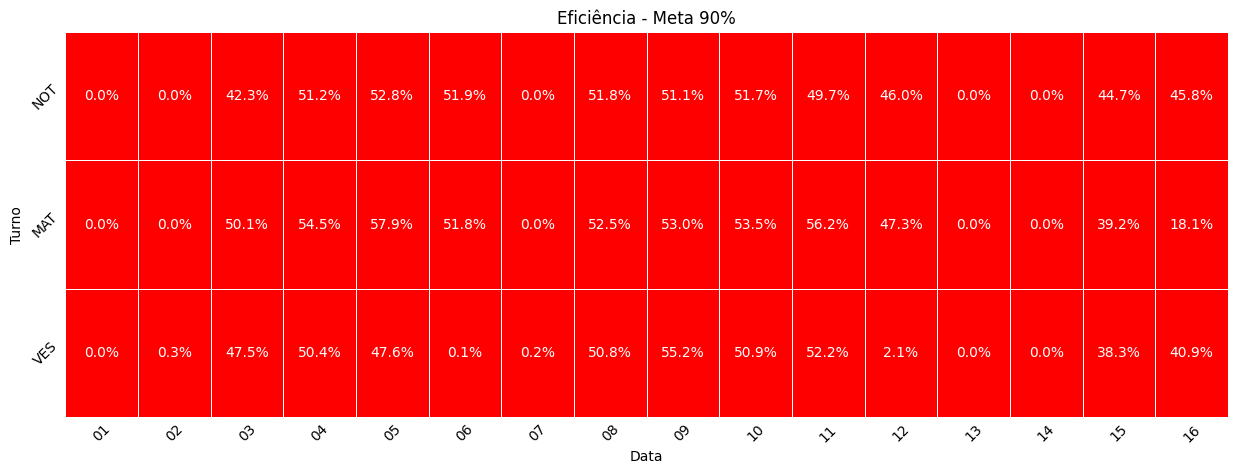

In [102]:
graph_heatmap_eff(df_eff, 90)
test(df_eff, 90)

In [103]:
# cSpell: words mcolors, eficiencia, vmin, vmax, cmap, figsize, linewidths, annot, cbar, xlabel,
# cSpell: words ylabel, xticks, yticks
def graph_heatmap_perf(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["performance"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="performance"
    )

    # Reordenar o índice do DataFrame

    df_pivot = df_pivot.reindex(["NOT", "MAT", "VES"])

    # Definir as cores baseado na eficiência

    colors = ["green", "green", "red", "red"]

    vmin, vmax = 0, 1  # Definir o intervalo de cores de 0 a 1

    norm = plt.Normalize(vmin, vmax)

    nodes = [
        vmin,
        0.04,
        0.041,
        vmax,
    ]  # Definir o ponto de mudança de cor para 4%

    cmap = mcolors.LinearSegmentedColormap.from_list(
        "", list(zip(nodes, colors))
    )

    # Criar o gráfico de calor

    plt.figure(figsize=(15, 5))

    sns.heatmap(
        df_pivot,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        annot=True,
        fmt=".1%",
        cbar=False,
    )

    plt.title(f"Performance - Meta {meta}%")

    plt.xlabel("Data")

    plt.ylabel("Turno")

    # Definir os rótulos do eixo x para os dias e rotacionar 45 graus

    days = [date[-2:] for date in df_pivot.columns]

    plt.xticks(ticks=plt.xticks()[0], labels=days, rotation=45)

    # Rotacionar os rótulos do eixo y

    plt.yticks(rotation=45)

    # Remover os ticks dos eixos x e y

    plt.gca().tick_params(axis="both", which="both", length=0)

    plt.show()

In [104]:
# cSpell: words mcolors, eficiencia, vmin, vmax, cmap, figsize, linewidths, annot, cbar, xlabel,
# cSpell: words ylabel, xticks, yticks
def graph_heatmap_perf_v2(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["performance"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="performance"
    )

    # Reordenar o índice do DataFrame
    df_pivot = df_pivot.reindex(["VES", "MAT", "NOT"])

    # Criar escala de cores personalizada
    colors = [[0, "green"], [0.04, "green"], [0.04, "red"], [1, "red"]]

    # Extrair apenas o dia da data
    df_pivot.columns = pd.to_datetime(df_pivot.columns).day

    # Criar o gráfico de calor
    fig = go.Figure(
        data=go.Heatmap(
            z=df_pivot.values,
            x=df_pivot.columns,
            y=df_pivot.index,
            colorscale=colors,
            zmin=0,
            zmax=1,  # Escala de valores de 0 a 1
            hoverongaps=False,
            hovertemplate="Turno: %{y}<br>Dia: %{x}<br>Valor: %{z:.1%}",
            showscale=False,  # Não mostrar a escala de cores
            xgap=1,  # Espaçamento entre os dias
            ygap=1,  # Espaçamento entre os turnos
        )
    )

    # Adicionar anotações com a média da eficiência
    # pylint: disable=consider-using-enumerate
    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns)):
            fig.add_annotation(
                x=df_pivot.columns[j],
                y=df_pivot.index[i],
                text=f"{df_pivot.values[i, j]:.1%}",
                showarrow=False,
                font=dict(color="white"),
            )

    # Definir o título do gráfico
    fig.update_layout(
        title=f"Performance - Meta {meta}%",
        xaxis_title="Dia",
        yaxis_title="Turno",
        title_x=0.5,  # Centralizar o título
        xaxis_nticks=31,  # Definir o número de dias
        xaxis=dict(
            tickmode="linear",
            tickvals=list(range(1, 32)),  # Definir os dias
            ticktext=list(range(1, 32)),  # Definir os dias
            tickangle=45,  # Rotacionar os dias
        ),
        yaxis=dict(
            tickmode="linear",
            tickangle=45,
        ),
        plot_bgcolor="white",
    )

    fig.show()

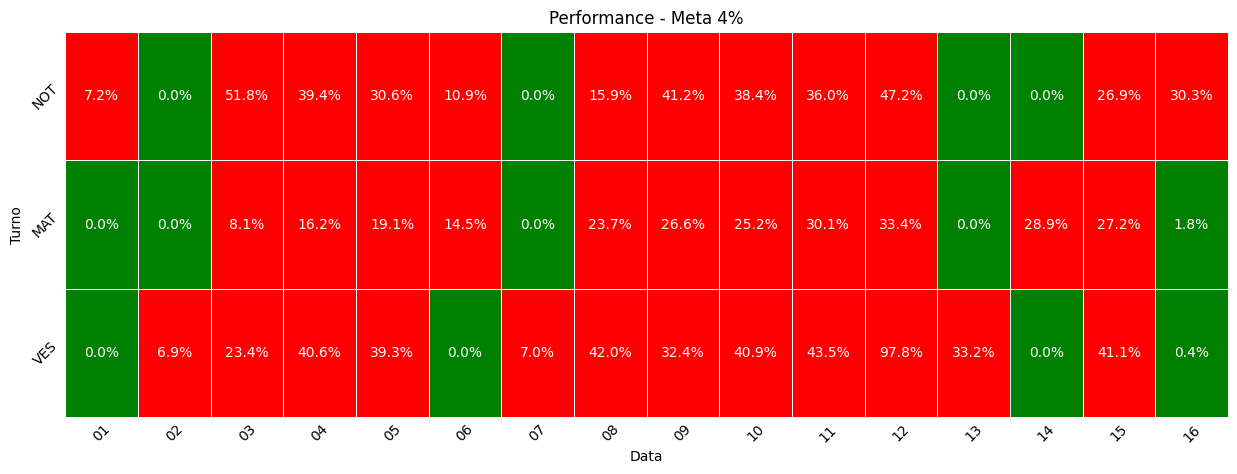

In [105]:
graph_heatmap_perf(df_perf, 4)
graph_heatmap_perf_v2(df_perf, 4)

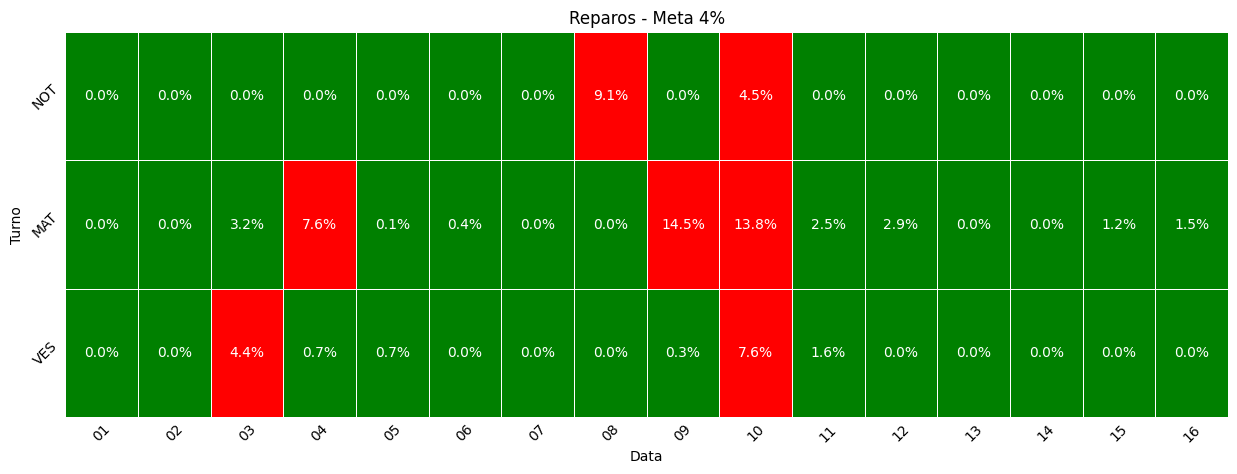

In [106]:
# cSpell: words mcolors, eficiencia, vmin, vmax, cmap, figsize, linewidths, annot, cbar, xlabel,
# cSpell: words ylabel, xticks, yticks
def graph_heatmap_reparos(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["reparo"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="reparo"
    )

    # Reordenar o índice do DataFrame

    df_pivot = df_pivot.reindex(["NOT", "MAT", "VES"])

    # Definir as cores baseado na eficiência

    colors = ["green", "green", "red", "red"]

    vmin, vmax = 0, 1  # Definir o intervalo de cores de 0 a 1

    norm = plt.Normalize(vmin, vmax)

    nodes = [
        vmin,
        0.04,
        0.041,
        vmax,
    ]  # Definir o ponto de mudança de cor para 4%

    cmap = mcolors.LinearSegmentedColormap.from_list(
        "", list(zip(nodes, colors))
    )

    # Criar o gráfico de calor

    plt.figure(figsize=(15, 5))

    sns.heatmap(
        df_pivot,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        annot=True,
        fmt=".1%",
        cbar=False,
    )

    plt.title(f"Reparos - Meta {meta}%")

    plt.xlabel("Data")

    plt.ylabel("Turno")

    # Definir os rótulos do eixo x para os dias e rotacionar 45 graus

    days = [date[-2:] for date in df_pivot.columns]

    plt.xticks(ticks=plt.xticks()[0], labels=days, rotation=45)

    # Rotacionar os rótulos do eixo y

    plt.yticks(rotation=45)

    # Remover os ticks dos eixos x e y

    plt.gca().tick_params(axis="both", which="both", length=0)

    plt.show()


reparos_map = graph_heatmap_reparos(df_reparos, 4)

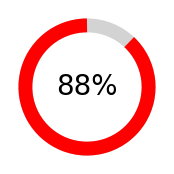

In [107]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def draw_circular_progress_bar(percentage):
    fig, ax = plt.subplots(figsize=(2, 2))

    # Desenhar o círculo de progresso
    bg_circle = patches.Circle(
        (0.5, 0.5), 0.4, edgecolor="lightgray", facecolor="white", lw=10
    )
    ax.add_patch(bg_circle)

    # Definir a cor com base na porcentagem
    color = "green" if percentage >= 0.9 else "red"

    progress_arc = patches.Arc(
        (0.5, 0.5),
        0.8,
        0.8,
        angle=90,
        theta1=0,
        theta2=percentage * 360,
        color=color,
        lw=10,
    )
    ax.add_patch(progress_arc)

    # Adicionar o valor da porcentagem no centro
    ax.text(
        0.5,
        0.5,
        f"{percentage * 100:.0f}%",
        ha="center",
        va="center",
        fontsize=20,
    )

    # Remover os eixos
    ax.axis("off")
    ax.set_aspect("equal")

    plt.show()


# Testar a função
draw_circular_progress_bar(0.88)  # 75%